In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

IMG_WIDTH, IMG_HEIGHT = 224, 224

import tensorflow_hub as hub
from tensorflow.keras.applications.densenet import (
    DenseNet121,
    preprocess_input,
)
import pandas as pd
import numpy as np
import os
import IPython.display as display
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    Conv2D,
    Flatten,
    GlobalMaxPooling2D,
    Dropout,
)

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from datetime import datetime
from packaging import version
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import (
    TensorBoard,
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
import efficientnet.tfkeras as enet


gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(
            len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs",
        )
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


def append_extension(fn):
    return (fn + ".jpg").zfill(7)


def ordered_logit(class_number):
    # zero portability
    target = np.zeros(4, dtype=int)
    target[: class_number - 2] = 1
    return target


DATADIR = r"./adult"
CSV_PATH = r"./adult/CastControls_ALP.xlsx"
response = pd.read_excel(CSV_PATH, sheet_name=0,)[["GreenID", "Grade"]].dropna(
    axis=0, subset=["Grade"]
)
response.Grade = response.Grade.astype("int")
response.GreenID = response.GreenID.astype("str").apply(append_extension)
response = response[response.Grade != 99]
response = pd.concat(
    [response, pd.DataFrame.from_dict(dict(response.Grade.apply(ordered_logit))).T,],
    axis=1,
)
response.Grade = response.Grade.astype("str")
response = response.sample(frac=1)
seed = np.random.randint(30027)


def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))


def soft_acc_multi_output(y_true, y_pred):
    return K.mean(
        K.all(
            K.equal(
                K.cast(K.round(y_true), "int32"), K.cast(K.round(y_pred), "int32"),
            ),
            axis=1,
        )
    )

from tensorflow.keras import mixed_precision

policy = tf.keras.mixed_precision.experimental.Policy("mixed_float16")
mixed_precision.experimental.set_policy(policy)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
train_gen = ImageDataGenerator(
    rotation_range=5,
    fill_mode="reflect",
    horizontal_flip=True,
    #     vertical_flip=True,
    validation_split=0.1,
    # dude i wasnt cheating...
    rescale=1.0 / 255.0,
    #     preprocessing_function = preprocess_input
    zoom_range=0.1,
)

valid_gen = ImageDataGenerator(validation_split=0.1, rescale=1.0 / 255.0,)

train_set = train_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224, 224),
    color_mode="rgb",
    subset="training",
    shuffle=True,
    #     class_mode = "sparse"
    #     y_col="Grade",
    y_col=[0, 1, 2, 3,],
    class_mode="raw",
)

validation_set = valid_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224, 224),
    color_mode="rgb",
    subset="validation",
    shuffle=True,
    batch_size=28,
    #     class_mode = "sparse"
    #     y_col="Grade",
    y_col=[0, 1, 2, 3,],
    class_mode="raw",
)

train_set.reset()
validation_set.reset()
# print(next(validation_set)[1].shape)

In [2]:
conv_base = enet.EfficientNetB0(
    include_top=False, input_shape=(224, 224, 3), pooling="avg", weights="imagenet",
)
conv_base.trainable = False

x = conv_base.output
x = Dropout(0.5)(x)
preds = Dense(4, activation="sigmoid")(x)
model = Model(inputs=conv_base.input, outputs=preds)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=[soft_acc_multi_output],
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=21, restore_best_weights=True,
)
reduce_lr_plateau = ReduceLROnPlateau(monitor="val_loss", patience=7, factor=0.8)

history_1 = model.fit_generator(
    generator=train_set,
    epochs=25,
    validation_data=validation_set,
    callbacks=[early_stopping, reduce_lr_plateau],
    #     verbose=0,
)

# model.save(
#     filepath="./saved_models/my_effnet/my_effnet_untuned_1_layer.h5", save_format="h5",
# )

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 16 steps, validate for 2 steps
Epoch 1/25
16/16 [==============================] - 11s 669ms/step - loss: 0.6069 - soft_acc_multi_output: 0.2124 - val_loss: 0.4696 - val_soft_acc_multi_output: 0.3571
Epoch 2/25
16/16 [==============================] - 5s 305ms/step - loss: 0.4838 - soft_acc_multi_output: 0.3115 - val_loss: 0.3935 - val_soft_acc_multi_output: 0.4286
Epoch 3/25
16/16 [==============================] - 5s 307ms/step - loss: 0.4403 - soft_acc_multi_output: 0.3268 - val_loss: 0.3645 - val_soft_acc_multi_output: 0.4643
Epoch 4/25
16/16 [==============================] - 5s 305ms/step - loss: 0.4071 - soft_acc_multi_output: 0.3978 - val_loss: 0.3524 - val_soft_acc_multi_output: 0.4821
Epoch 5/25
16/16 [==============================] - 5s 304ms/step - loss: 0.4045 - soft_acc_multi_output: 0.3818 - val_loss: 0.3363 - val_soft_acc_multi_output:

In [4]:
#########################
## fine tuning
#########################


fine_tune = [layer.name for layer in model.layers].index(r"top_conv")

model.trainable = True
for layer in model.layers[:fine_tune]:
    layer.trainable = False
for layer in model.layers[fine_tune:]:
    layer.trainable = True

print(
    f"from {fine_tune} of {len(model.layers)} layers; {len(model.trainable_variables)} trainables variables"
)
model.compile(
    optimizer=keras.optimizers.Nadam(),
    loss="binary_crossentropy",
    metrics=[soft_acc_multi_output],
)
train_set.reset()
validation_set.reset()


# logdir_name = (
#     r".\tfb\logs\effnet\\"
#     + "effnet__1_layer"
#     + "__"
#     + datetime.now().strftime("%Y%m%d-%H%M%S")
# )
# tensorboard_callback = TensorBoard(log_dir=logdir_name)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=21, restore_best_weights=True,
)
reduce_lr_plateau = ReduceLROnPlateau(monitor="val_loss", patience=7, factor=0.8)

# initial epoch is useless for keras optimizers as they update internally independent of epoch number
history_fine = model.fit_generator(
    generator=train_set,
    epochs=100,
    validation_data=validation_set,
    callbacks=[early_stopping, reduce_lr_plateau,],
)

# model.save(
#     filepath="./saved_models/my_effnet/tuned_1_layer.h5", save_format="h5",
# )
# model.save_weights(
#     "./saved_models/my_effnet/tuned_1_layer_weights_only.h5", save_format="h5",
# )

from 227 of 233 layers; 5 trainables variables
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 16 steps, validate for 2 steps
Epoch 1/100
16/16 [==============================] - 11s 679ms/step - loss: 0.5760 - soft_acc_multi_output: 0.3372 - val_loss: 0.3130 - val_soft_acc_multi_output: 0.5536
Epoch 2/100
16/16 [==============================] - 5s 311ms/step - loss: 0.3600 - soft_acc_multi_output: 0.5082 - val_loss: 0.3111 - val_soft_acc_multi_output: 0.5714
Epoch 3/100
16/16 [==============================] - 5s 303ms/step - loss: 0.3116 - soft_acc_multi_output: 0.5399 - val_loss: 0.3271 - val_soft_acc_multi_output: 0.5536
Epoch 4/100
16/16 [==============================] - 5s 312ms/step - loss: 0.2968 - soft_acc_multi_output: 0.5624 - val_loss: 0.3075 - val_soft_acc_multi_output: 0.5714
Epoch 5/100
16/16 [==============================] - 5s 316ms/step - loss: 0.2799 - soft_acc_multi_output: 0.5781 - val_loss: 0.3050 - val_soft_acc_multi_output: 0.5536
Epoch 6/100
16/1

In [19]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []

# model__ = tf.keras.models.load_model(
#     "./saved_models/my_effnet/tuned_1_layer.h5",
#     custom_objects={"soft_acc_multi_output": soft_acc_multi_output},
# )

# model__.trainable = False
# len(model__.trainable_variables)
# model__.compile(
#         optimizer=keras.optimizers.Nadam(learning_rate=0.0001),
#         loss="binary_crossentropy",
#         metrics=[soft_acc_multi_output],
#     )

model__ = generate_base_model()

In [20]:
traintest = list(kf.split(np.zeros(len(response)), response["Grade"]))
train_index, test_index = np.stack(traintest)[:, 0][0], np.stack(traintest)[:, 1][0]


train_gen = ImageDataGenerator(
    rotation_range=5,
    fill_mode="reflect",
    horizontal_flip=True,
    validation_split=0,
    rescale=1.0 / 255.0,
    zoom_range=0.1,
)
valid_gen = ImageDataGenerator(validation_split=0.5, rescale=1.0 / 255.0,)

train_set = train_gen.flow_from_dataframe(
    dataframe=response.iloc[train_index],
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224, 224),
    color_mode="rgb",
    subset="training",
    shuffle=False,
    y_col=[0, 1, 2, 3,],
    class_mode="raw",
)

validation_set = valid_gen.flow_from_dataframe(
    dataframe=response.iloc[test_index],
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224, 224),
    color_mode="rgb",
    subset="training",
    shuffle=True,
    batch_size=64,
    y_col=[0, 1, 2, 3,],
    class_mode="raw",
)

test_set = valid_gen.flow_from_dataframe(
    dataframe=response.iloc[test_index],
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224, 224),
    color_mode="rgb",
    subset="validation",
    shuffle=True,
    batch_size=64,
    y_col=[0, 1, 2, 3,],
    class_mode="raw",
)

Found 450 validated image filenames.
Found 57 validated image filenames.
Found 56 validated image filenames.


C:\Users\feroc\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 5 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\feroc\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [22]:
model__ = fine_tune_model(model__,)

In [23]:
# batch = next(test_set)
# true_labels = batch[1]
# predictions = model__.predict(batch[0])

# print(model__.metrics_names)
# print(
#     model__.evaluate(train_set, verbose=0)
# )  # working well with original unstratified model, including both trainning and testing sets?

model__.fit(
    x=train_set,
    epochs=10,
    validation_data=validation_set,
    callbacks=[early_stopping, reduce_lr_plateau],
    #         verbose=0,
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 1 steps
Epoch 1/10
15/15 [==============================] - 10s 647ms/step - loss: 0.8732 - soft_acc_multi_output: 0.1500 - val_loss: 0.4139 - val_soft_acc_multi_output: 0.3684
Epoch 2/10
15/15 [==============================] - 4s 288ms/step - loss: 0.7882 - soft_acc_multi_output: 0.1792 - val_loss: 0.4187 - val_soft_acc_multi_output: 0.3509
Epoch 3/10
15/15 [==============================] - 4s 287ms/step - loss: 0.6969 - soft_acc_multi_output: 0.1937 - val_loss: 0.4258 - val_soft_acc_multi_output: 0.4211
Epoch 4/10
15/15 [==============================] - 4s 291ms/step - loss: 0.6181 - soft_acc_multi_output: 0.2625 - val_loss: 0.4342 - val_soft_acc_multi_output: 0.4035
Epoch 5/10
15/15 [==============================] - 4s 288ms/step - loss: 0.5712 - soft_acc_multi_output: 0.2750 - val_loss: 0.4419 - val_soft_acc_multi_output: 0.4737
Epoch 6/10
15/15 [==============================] - 4s 288ms/step - 

In [4]:
def generate_base_model():
    conv_base = enet.EfficientNetB0(
        include_top=False, input_shape=(224, 224, 3), pooling="avg", weights="imagenet",
    )
    conv_base.trainable = False

    x = conv_base.output
    x = Dropout(0.5)(x)
    preds = Dense(5, activation="softmax")(x)
    model = Model(inputs=conv_base.input, outputs=preds)

    model.compile(
        optimizer=keras.optimizers.Nadam(lr=0.0014),
        loss="categorical_crossentropy",
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
    )

    return model


def fine_tune_model(model, fine_tune=None):
    if fine_tune is None:
        try:
            fine_tune = [layer.name for layer in model.layers].index(r"top_conv")
        except:
            pass

    model.trainable = True
    for layer in model.layers[:fine_tune]:
        layer.trainable = False
    for layer in model.layers[fine_tune:]:
        layer.trainable = True

    model.compile(
        optimizer=keras.optimizers.Nadam(lr=0.0003),
        loss="categorical_crossentropy",
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
    )

    return model


def generate_train_val_test(train_index, val_index, test_index):
    train_dataset = response.iloc[train_index]
    val_dataset = response.iloc[val_index]
    test_dataset = response.iloc[test_index]
    train_gen = ImageDataGenerator(
        rotation_range=5,
        fill_mode="reflect",
        horizontal_flip=True,
        rescale=1.0 / 255.0,
        zoom_range=0.1,
    )
    valid_test_gen = ImageDataGenerator(rescale=1.0 / 255.0,)

    train_set = train_gen.flow_from_dataframe(
        dataframe=train_dataset,
        directory=DATADIR,
        x_col="GreenID",
        target_size=(224, 224),
        color_mode="rgb",
        subset="training",
        shuffle=True,
        y_col="Grade",
    )

    validation_set = valid_test_gen.flow_from_dataframe(
        dataframe=val_dataset,
        directory=DATADIR,
        x_col="GreenID",
        target_size=(224, 224),
        color_mode="rgb",
        subset="training",
        shuffle=False,
        batch_size=64,
        y_col="Grade",
    )

    test_set = valid_test_gen.flow_from_dataframe(
        dataframe=test_dataset,
        directory=DATADIR,
        x_col="GreenID",
        target_size=(224, 224),
        color_mode="rgb",
        subset="training",
        shuffle=False,
        batch_size=64,
        y_col="Grade",
    )
    return train_set, validation_set, test_set


from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
innerkf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
response = response.sample(frac=1.0)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=21, restore_best_weights=True,
)
reduce_lr_plateau = ReduceLROnPlateau(monitor="val_loss", patience=7, factor=0.8)

In [5]:
import gc
def stratified_cv(fine_tune_layer=None):
    acc_coef_scores = []
    raw_outputs = []
    for train_index, val_test_index in kf.split(
        np.zeros(len(response)), response["Grade"]
    ):
        val_index, test_index = next(
            innerkf.split(
                np.zeros(len(val_test_index)), response["Grade"].iloc[val_test_index]
            )
        )
        val_index, test_index = val_test_index[val_index], val_test_index[test_index]
        train_set, validation_set, test_set = generate_train_val_test(
            train_index, val_index, test_index
        )
        model = generate_base_model()

        _ = model.fit(
            x=train_set,
            epochs=15,
            validation_data=validation_set,
            callbacks=[early_stopping, reduce_lr_plateau],
            verbose=0,
        )

        model = fine_tune_model(model, fine_tune=fine_tune_layer)

        _ = model.fit(
            x=train_set,
            epochs=100,
            validation_data=validation_set,
            callbacks=[early_stopping, reduce_lr_plateau],
            verbose=0,
        )

        batch = next(test_set)
        true_labels = batch[1]
        predictions = model.predict(batch[0])
        acc = soft_acc_multi_output(predictions, true_labels).numpy()
        corr = np.corrcoef(np.argmax(predictions, axis=1),np.argmax(true_labels, axis=1))[0][
            1
        ]
        acc_coef_scores.append([acc, corr])
        raw_outputs.append([np.array(response.iloc[test_index].index), true_labels, predictions])
        del train_set, validation_set, test_set, _, model, batch, true_labels, predictions, acc, corr
        tf.keras.backend.clear_session()
        gc.collect()
    return acc_coef_scores, raw_outputs

In [ ]:
#  np.where(np.array(['conv' in layer.name for layer in model.layers]) == True)[0][::-1]
trainable_sequence = np.array([227, 225, 217, 214, 210, 202, 199, 195, 187, 184, 180, 172, 169,
       167, 159, 156, 152, 144, 141, 137, 129, 126, 124, 116, 113, 109,
       101,  98,  94,  86,  83,  81,  73,  70,  66,  58,  55,  53,  45,
        42,  38,  30,  27,  25,  17,  14,  12,   4,   1])

fine_tune_scores_acc_coef = []
fine_tune_raw_outputs = []

for fine_tune in trainable_sequence[9:20]:
    acc_coef_scores, raw_outputs = stratified_cv(fine_tune)
    fine_tune_scores_acc_coef.append(acc_coef_scores)
    fine_tune_raw_outputs.append(raw_outputs)
    np.save(r"./stratified_cross_validation_results/effnets/onehot_acc_coef_9-20", np.array(fine_tune_scores_acc_coef))
    np.save(r"./stratified_cross_validation_results/effnets/onehot_raw_outputs_9-20", np.array(fine_tune_raw_outputs))
    del acc_coef_scores, raw_outputs
    tf.keras.backend.clear_session()
    gc.collect()


10
[[39  4  0  0  0]
 [28 18  8  1  0]
 [37  6 26  2  9]
 [11  4  6 18 10]
 [ 7  0  6  6 36]]
+++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++
[[0.90697674 0.09302326 0.         0.         0.        ]
 [0.50909091 0.32727273 0.14545455 0.01818182 0.        ]
 [0.4625     0.075      0.325      0.025      0.1125    ]
 [0.2244898  0.08163265 0.12244898 0.36734694 0.20408163]
 [0.12727273 0.         0.10909091 0.10909091 0.65454545]]
+++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++
0.4858156028368794
+++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++
max accuracy with tuning from 195 layers, or tune 38 layers


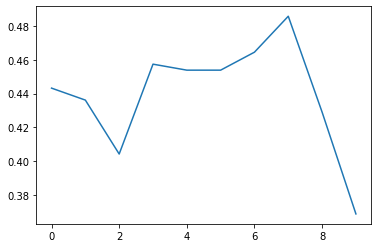

In [4]:
import numpy as np

acc_coef = np.load(r"./stratified_cross_validation_results/effnets/onehot_acc_coef_0-9.npy", allow_pickle=True)
raw_outputs = np.load(r"./stratified_cross_validation_results/effnets/onehot_raw_outputs_0-9.npy", allow_pickle=True)
print(len(acc_coef))


from sklearn.metrics import confusion_matrix


def show_confusion_matrix(raw_outputs, fine_tune_layers):

    y_true = np.argmax(np.vstack(raw_outputs[fine_tune_layers, :, 1]), axis=1)
    y_pred = np.argmax(
        np.rint(np.vstack(raw_outputs[fine_tune_layers, :, 2])), axis=1
    ).astype(int)
    return confusion_matrix(y_true, y_pred)

def show_matrix_percentage(confusion_matrix):
    return np.transpose(np.transpose(my_confusion_matrix) / np.sum(my_confusion_matrix, axis=1))

# total accuracy
def calculate_accuracy(my_confusion_matrix):
    return np.trace(my_confusion_matrix)/np.sum(my_confusion_matrix)

max_acc_layer = np.argmax([calculate_accuracy(show_confusion_matrix(raw_outputs, i))  for i in range(len(acc_coef))])

my_confusion_matrix = show_confusion_matrix(raw_outputs,max_acc_layer)
print(my_confusion_matrix)
print("+++++++++++++++++++++++++++++++++")
print("+++++++++++++++++++++++++++++++++")
print(show_matrix_percentage(my_confusion_matrix))
print("+++++++++++++++++++++++++++++++++")
print("+++++++++++++++++++++++++++++++++")
print(calculate_accuracy(my_confusion_matrix))

import matplotlib.pyplot as plt
plt.plot([i for i in range(len(acc_coef))],[calculate_accuracy(show_confusion_matrix(raw_outputs, i))  for i in range(len(acc_coef))])
print("+++++++++++++++++++++++++++++++++")
print("+++++++++++++++++++++++++++++++++")
trainable_sequence = np.array([227, 225, 217, 214, 210, 202, 199, 195, 187, 184, 180, 172, 169,
       167, 159, 156, 152, 144, 141, 137, 129, 126, 124, 116, 113, 109,
       101,  98,  94,  86,  83,  81,  73,  70,  66,  58,  55,  53,  45,
        42,  38,  30,  27,  25,  17,  14,  12,   4,   1])
print(f"max accuracy with tuning from {trainable_sequence[max_acc_layer]} layers, or tune {233-trainable_sequence[max_acc_layer]} layers")

In [76]:
np.array(cvscores)[:, 1][:, 0][4].shape

(56, 4)

In [26]:
np.array(cvscores)[:, 0]

array([[0.54385966, 0.7954881615019466],
       [0.5964912, 0.851205445137053],
       [0.4107143, 0.7907964869050351],
       [0.54545456, 0.8426871818521864],
       [0.66071427, 0.8581865352844125]], dtype=object)

In [28]:
from sklearn.metrics import confusion_matrix

confusion_matrix(
    y_true=K.sum(K.cast(K.round(cvscores[1][1][0]), "int32"), axis=1).numpy(),
    y_pred=K.sum(K.cast(K.round(cvscores[1][1][1]), "int32"), axis=1).numpy(),
)

array([[ 5,  3,  1,  0,  0],
       [ 0,  9,  3,  0,  0],
       [ 1,  4, 11,  0,  0],
       [ 0,  0,  3,  5,  3],
       [ 0,  0,  1,  3,  5]], dtype=int64)

In [118]:
mycsv = pd.DataFrame(
    np.hstack(
        np.array(
            [
                np.vstack(np.array(cvscores)[:, 1][:, 0]),
                np.vstack(np.array(cvscores)[:, 1][:, 1]),
            ]
        )
    )
)

In [117]:
np.allclose(mycsv[range(4, 8)].to_numpy(), np.vstack(np.array(cvscores)[:, 1][:, 1]))

True

In [119]:
mycsv.to_csv(
    "./stratified_cross_validation_results/effnet_multinomial.csv", index=False
)
# next time include which image?

In [175]:
mycsv = pd.read_csv("./stratified_cross_validation_results/effnet_multinomial.csv")
y_true = np.sum((mycsv[[str(i) for i in range(0, 4)]]).to_numpy(dtype=int), axis=1)
y_pred = np.sum(
    np.rint((mycsv[[str(i) for i in range(4, 8)]]).to_numpy()), axis=1
).astype(int)

In [176]:
from sklearn.metrics import confusion_matrix

my_confusion_matrix = confusion_matrix(y_true, y_pred,)
my_confusion_matrix

array([[33, 10,  1,  0,  0],
       [ 6, 36, 14,  1,  0],
       [ 7, 22, 35,  5,  4],
       [ 0,  2, 20, 17,  9],
       [ 0,  0,  7, 17, 35]], dtype=int64)

In [177]:
np.transpose(np.transpose(my_confusion_matrix) / np.sum(my_confusion_matrix, axis=1))

array([[0.75      , 0.22727273, 0.02272727, 0.        , 0.        ],
       [0.10526316, 0.63157895, 0.24561404, 0.01754386, 0.        ],
       [0.09589041, 0.30136986, 0.47945205, 0.06849315, 0.05479452],
       [0.        , 0.04166667, 0.41666667, 0.35416667, 0.1875    ],
       [0.        , 0.        , 0.11864407, 0.28813559, 0.59322034]])

In [188]:
# coef
np.corrcoef(y_true, np.sum((mycsv[[str(i) for i in range(4, 8)]]).to_numpy(), axis=1))

array([[1.        , 0.82710261],
       [0.82710261, 1.        ]])

In [189]:
# acc
sum(np.isclose(y_true, y_pred)) / len(y_pred)

0.5551601423487544

In [ ]:
# from tensorflow.keras.utils import plot_model

# plot_model(model, to_file="effnet.png", show_shapes=True)
# from IPython.display import Image

# Image(filename="effnet.png")

In [45]:
response = response.sample(frac=1.0)

test_set = valid_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224, 224),
    color_mode="rgb",
    subset="validation",
    shuffle=False,
    batch_size=56,
    y_col=[0, 1, 2, 3,],
    class_mode="raw",
    #     seed = seed
)

batch = next(test_set)
true_labels = batch[1]
predictions = model.predict(batch[0])

print(model.metrics_names)
print(model.evaluate(test_set, verbose=0))  # loss/accuracy

Found 281 validated image filenames.
['loss', 'soft_acc_multi_output']
  ...
    to  
  ['...']
[0.21299249678850174, 0.74404764]


In [46]:
np.corrcoef(np.sum(predictions, axis=1), np.sum(true_labels, axis=1))

array([[1.        , 0.85824516],
       [0.85824516, 1.        ]])

tf.Tensor(0.71428573, shape=(), dtype=float32)


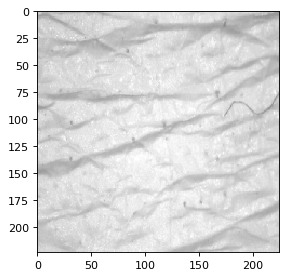

true label: [1 1 1 0]; rounded pred: [0.9458005  0.86420625 0.9528389  0.49384445]; Correct: True


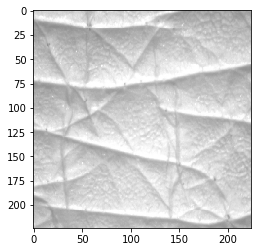

true label: [1 1 0 0]; rounded pred: [0.8466992  0.05355815 0.05508953 0.00393348]; Correct: False


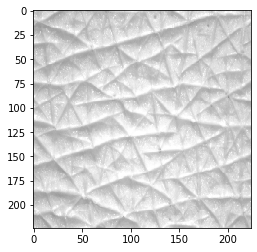

true label: [0 0 0 0]; rounded pred: [0.4074192  0.10599262 0.02915193 0.00905077]; Correct: True


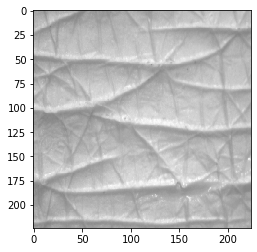

true label: [1 0 0 0]; rounded pred: [0.83252347 0.26864362 0.06925142 0.01915411]; Correct: True


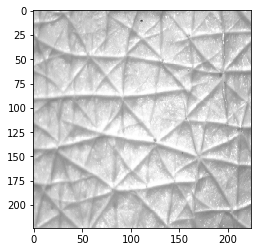

true label: [0 0 0 0]; rounded pred: [0.01489217 0.00957016 0.00044385 0.00051464]; Correct: True


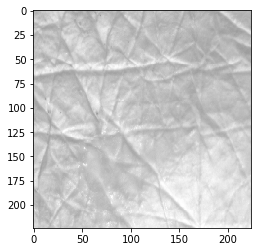

true label: [1 1 0 0]; rounded pred: [0.9824897  0.9643462  0.8155724  0.79195064]; Correct: False


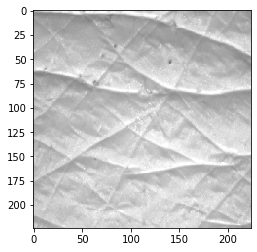

true label: [1 1 1 0]; rounded pred: [0.99910057 0.9643583  0.75259113 0.03605417]; Correct: True


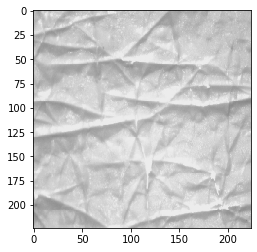

true label: [1 1 1 0]; rounded pred: [0.98124206 0.811368   0.80762166 0.52631944]; Correct: False


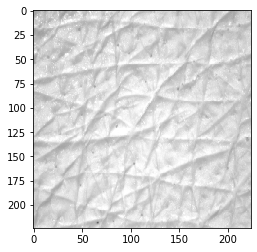

true label: [1 1 1 0]; rounded pred: [0.6997654 0.4881794 0.4195442 0.1767267]; Correct: False


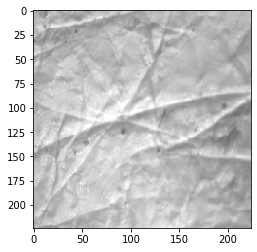

true label: [1 1 1 1]; rounded pred: [0.98515594 0.9611719  0.9396358  0.80024207]; Correct: True


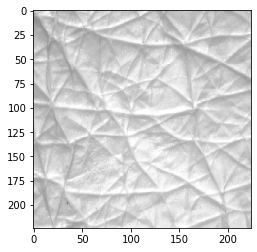

true label: [1 1 0 0]; rounded pred: [0.81274056 0.7673472  0.03582735 0.04319824]; Correct: True


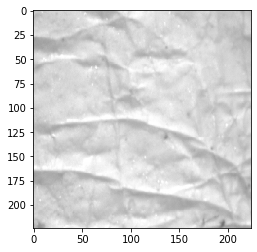

true label: [1 1 1 1]; rounded pred: [0.97425044 0.95204896 0.95930874 0.8756842 ]; Correct: True


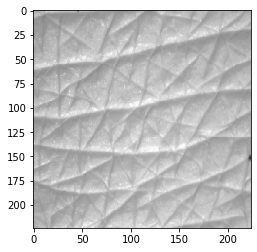

true label: [0 0 0 0]; rounded pred: [0.3201091  0.06409606 0.0506062  0.01334843]; Correct: True


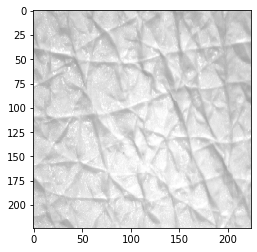

true label: [1 1 0 0]; rounded pred: [0.95121485 0.90324694 0.27169862 0.34651196]; Correct: True


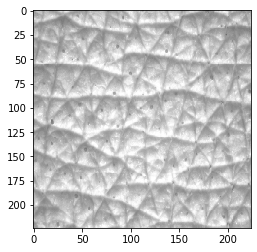

true label: [0 0 0 0]; rounded pred: [0.03395272 0.01996435 0.00706074 0.006744  ]; Correct: True


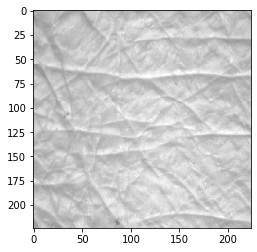

true label: [1 1 1 0]; rounded pred: [0.98511374 0.8533159  0.75866985 0.28169158]; Correct: True


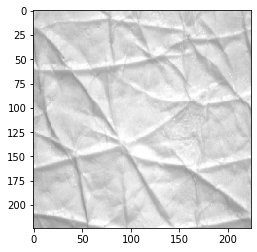

true label: [1 1 0 0]; rounded pred: [0.98768973 0.9457818  0.41268328 0.26607886]; Correct: True


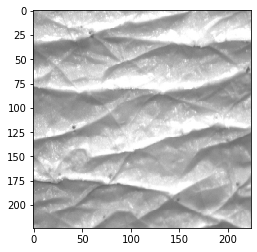

true label: [1 1 0 0]; rounded pred: [0.9805611  0.65920013 0.51749164 0.07821194]; Correct: False


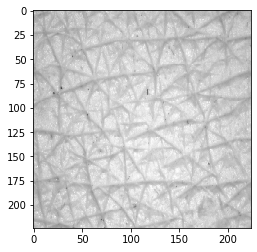

true label: [0 0 0 0]; rounded pred: [0.08066282 0.08329639 0.01782535 0.01298986]; Correct: True


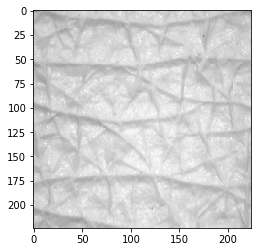

true label: [1 0 0 0]; rounded pred: [0.5092851  0.16377395 0.09307262 0.07526767]; Correct: True


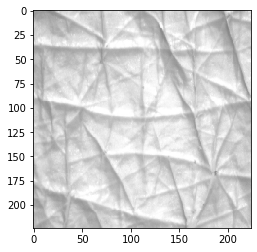

true label: [1 1 1 0]; rounded pred: [0.99140126 0.9729212  0.33896357 0.21122658]; Correct: False


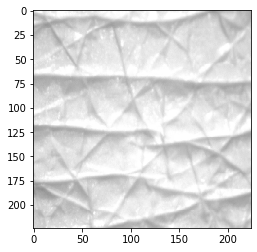

true label: [1 0 0 0]; rounded pred: [0.7933497  0.26485947 0.10757885 0.03733648]; Correct: True


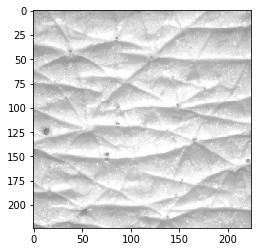

true label: [1 0 0 0]; rounded pred: [0.7801601  0.16194503 0.1380542  0.02534726]; Correct: True


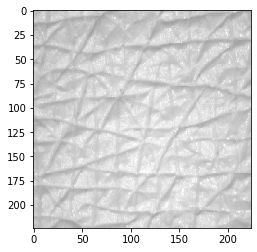

true label: [0 0 0 0]; rounded pred: [0.29891545 0.0982215  0.09862573 0.04001846]; Correct: True


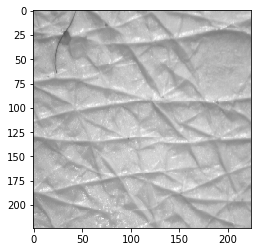

true label: [1 1 0 0]; rounded pred: [0.9670451  0.9005038  0.15669502 0.05440214]; Correct: True


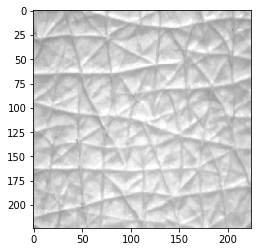

true label: [0 0 0 0]; rounded pred: [0.61270607 0.4901639  0.00375035 0.00666767]; Correct: False


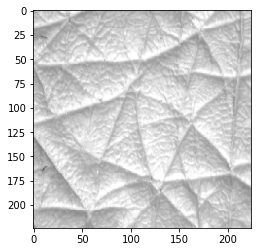

true label: [0 0 0 0]; rounded pred: [0.634808   0.13030283 0.10907105 0.02403732]; Correct: False


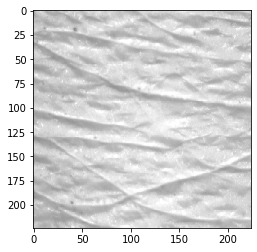

true label: [1 1 1 1]; rounded pred: [0.98388624 0.97456837 0.98866045 0.66901904]; Correct: True


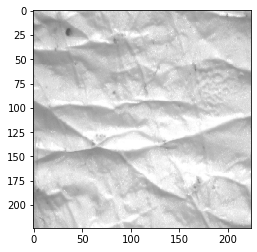

true label: [1 1 1 1]; rounded pred: [0.988781   0.88107616 0.83573806 0.34247297]; Correct: False


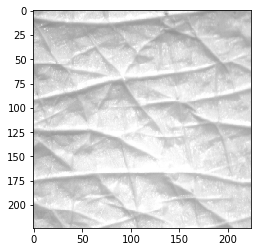

true label: [1 0 0 0]; rounded pred: [0.92618984 0.3544096  0.13371707 0.01004518]; Correct: True


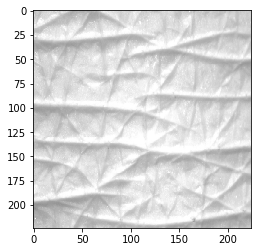

true label: [1 0 0 0]; rounded pred: [0.8809787  0.12784684 0.16003759 0.01950472]; Correct: True


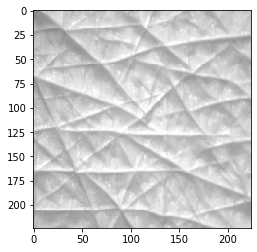

true label: [1 1 0 0]; rounded pred: [0.93475693 0.5332919  0.0609949  0.00795051]; Correct: True


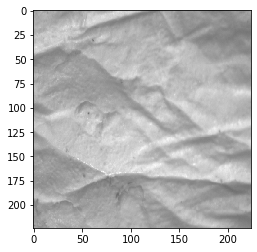

true label: [1 1 1 1]; rounded pred: [0.982578   0.95789814 0.9680729  0.7315114 ]; Correct: True


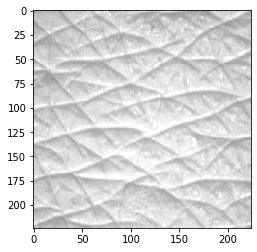

true label: [1 1 0 0]; rounded pred: [0.8454192  0.2675416  0.08534671 0.00822576]; Correct: False


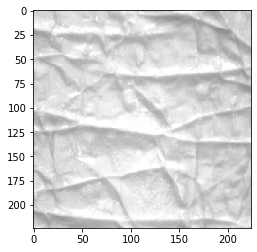

true label: [1 1 1 0]; rounded pred: [0.98908955 0.80627054 0.7788701  0.39655533]; Correct: True


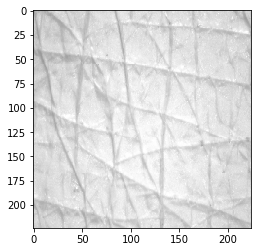

true label: [1 1 0 0]; rounded pred: [0.9683999  0.93648493 0.31772354 0.11764962]; Correct: True


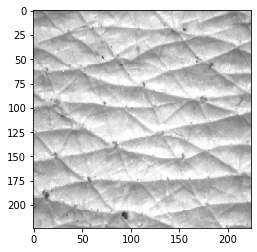

true label: [1 0 0 0]; rounded pred: [0.42355576 0.03018976 0.03092927 0.00719702]; Correct: False


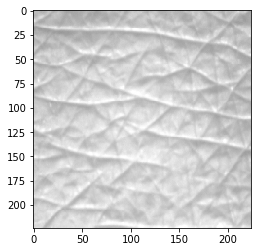

true label: [1 1 0 0]; rounded pred: [0.9710537  0.7058414  0.16347748 0.03338694]; Correct: True


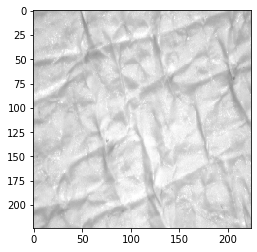

true label: [1 1 1 1]; rounded pred: [0.9883073  0.9834645  0.90143013 0.91051346]; Correct: True


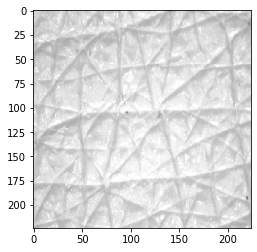

true label: [1 1 0 0]; rounded pred: [0.63001025 0.6446196  0.01962836 0.01978948]; Correct: True


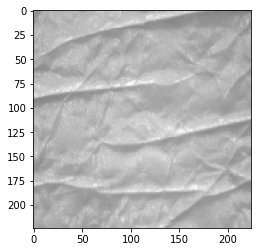

true label: [1 1 1 1]; rounded pred: [0.99607086 0.97229946 0.94571537 0.45764634]; Correct: False


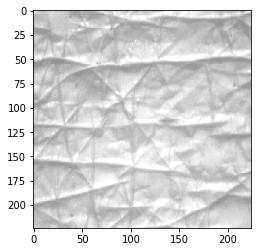

true label: [1 1 1 1]; rounded pred: [0.9751881  0.9200669  0.79681057 0.5566864 ]; Correct: True


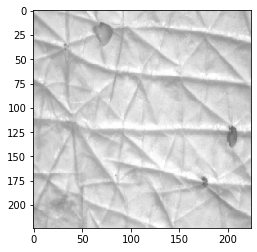

true label: [0 0 0 0]; rounded pred: [0.60063535 0.2650309  0.01769987 0.00715721]; Correct: False


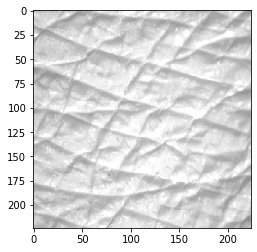

true label: [1 1 1 1]; rounded pred: [0.95780814 0.88730377 0.62364763 0.4449324 ]; Correct: False


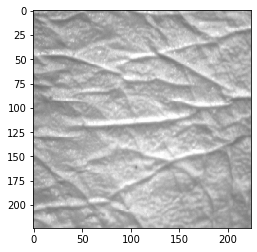

true label: [1 1 1 1]; rounded pred: [0.96500444 0.8296286  0.89321566 0.6404109 ]; Correct: True


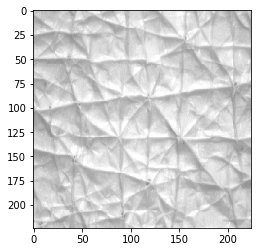

true label: [1 1 0 0]; rounded pred: [0.8953771  0.85449374 0.03896132 0.03743229]; Correct: True


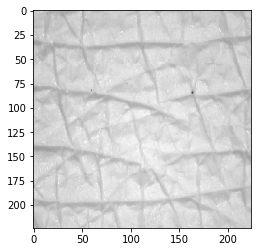

true label: [1 0 0 0]; rounded pred: [0.86202735 0.60268277 0.14085436 0.08674004]; Correct: False


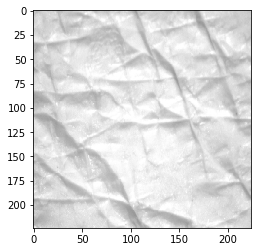

true label: [1 1 1 1]; rounded pred: [0.989358  0.9685103 0.9014564 0.8549609]; Correct: True


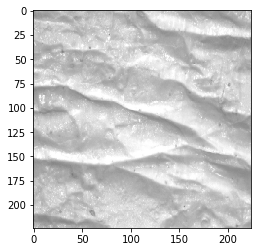

true label: [1 1 1 0]; rounded pred: [0.9965803  0.98595166 0.98293465 0.36049885]; Correct: True


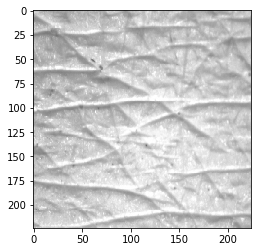

true label: [1 1 1 0]; rounded pred: [0.9597262  0.7077676  0.85202044 0.20077476]; Correct: True


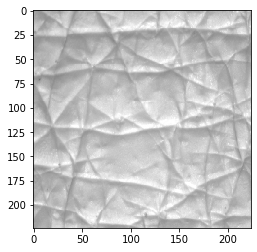

true label: [1 1 0 0]; rounded pred: [0.8503983  0.72800714 0.04050406 0.03926633]; Correct: True


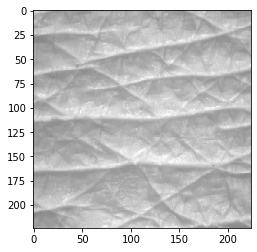

true label: [1 1 1 0]; rounded pred: [0.9501294  0.4513823  0.43516934 0.04228188]; Correct: False


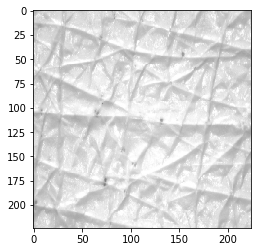

true label: [1 1 0 0]; rounded pred: [0.9746406  0.9311937  0.23410778 0.21046226]; Correct: True


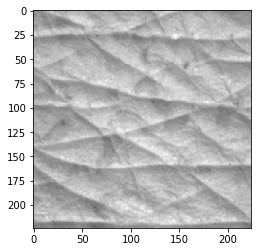

true label: [1 0 0 0]; rounded pred: [0.8472815  0.17863405 0.18545105 0.01228757]; Correct: True


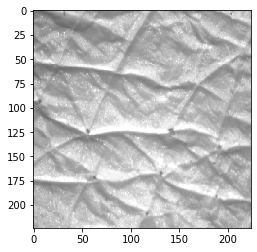

true label: [1 1 0 0]; rounded pred: [0.9507097  0.77458    0.45915517 0.15366156]; Correct: True


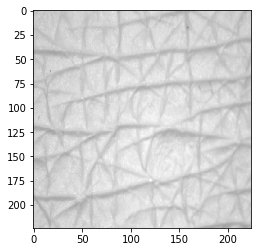

true label: [0 0 0 0]; rounded pred: [0.09537912 0.05828505 0.03377274 0.01964102]; Correct: True


In [47]:
fig, ax = plt.subplots(dpi=80)
batch = next(test_set)

y_true = batch[1]
y_pred = model.predict(batch[0])
print(soft_acc_multi_output(y_true, y_pred))

# print examples from the validation set
for i in range(len(batch[1])):
    img = batch[0][i]
    label = batch[1][i]
    assert (label == y_true[i]).all()
    right = K.all(
        K.equal(K.cast(K.round(label), "int32"), K.cast(K.round(y_pred[i]), "int32"),)
    )
    plt.imshow(img)
    plt.show()
    print(f"true label: {label}; rounded pred: {y_pred[i]}; Correct: {right}")

In [ ]:
list_ds = tf.data.Dataset.list_files(
    str("C:/Users/feroc/OneDrive - The University of Melbourne/Dataset/adult/*")
)


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


def get_label(file_path):
    # convert the path to a list of path components
    image_id = tf.strings.split(file_path, os.path.sep)[-1]
    return response.loc[] 

list(list_ds.take(1).as_numpy_iterator())[0]
tf.strings.split(list(list_ds.take(1).as_numpy_iterator())[0],os.path.sep)[-1].numpy()